In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,OrdinalEncoder,PolynomialFeatures
from sklearn.linear_model import LinearRegression , Ridge , Lasso , ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_data = '/kaggle/input/used-cars-price-prediction/train-data.csv'
test_data = '/kaggle/input/used-cars-price-prediction/test-data.csv'

# Exploratory Data Analysis (EDA)

In [4]:
df = pd.read_csv(train_data)
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [5]:
df_test = pd.read_csv(test_data)
df_test.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,0,Maruti Alto K10 LXI CNG,Delhi,2014,40929,CNG,Manual,First,32.26 km/kg,998 CC,58.2 bhp,4.0,NaN
1,1,Maruti Alto 800 2016-2019 LXI,Coimbatore,2013,54493,Petrol,Manual,Second,24.7 kmpl,796 CC,47.3 bhp,5.0,NaN
2,2,Toyota Innova Crysta Touring Sport 2.4 MT,Mumbai,2017,34000,Diesel,Manual,First,13.68 kmpl,2393 CC,147.8 bhp,7.0,25.27 Lakh
3,3,Toyota Etios Liva GD,Hyderabad,2012,139000,Diesel,Manual,First,23.59 kmpl,1364 CC,null bhp,5.0,NaN
4,4,Hyundai i20 Magna,Mumbai,2014,29000,Petrol,Manual,First,18.5 kmpl,1197 CC,82.85 bhp,5.0,NaN


In [6]:
df.columns = df.columns.str.lower()

In [7]:
df.shape

(6019, 14)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   unnamed: 0         6019 non-null   int64  
 1   name               6019 non-null   object 
 2   location           6019 non-null   object 
 3   year               6019 non-null   int64  
 4   kilometers_driven  6019 non-null   int64  
 5   fuel_type          6019 non-null   object 
 6   transmission       6019 non-null   object 
 7   owner_type         6019 non-null   object 
 8   mileage            6017 non-null   object 
 9   engine             5983 non-null   object 
 10  power              5983 non-null   object 
 11  seats              5977 non-null   float64
 12  new_price          824 non-null    object 
 13  price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


In [9]:
df.isnull().sum()

unnamed: 0              0
name                    0
location                0
year                    0
kilometers_driven       0
fuel_type               0
transmission            0
owner_type              0
mileage                 2
engine                 36
power                  36
seats                  42
new_price            5195
price                   0
dtype: int64

In [10]:
df.duplicated().sum()

0

In [11]:
df.drop(['unnamed: 0','new_price'], axis  = 1 , inplace = True)
df.head()

,name,location,year,kilometers_driven,fuel_type,transmission,owner_type,mileage,engine,power,seats,price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


In [12]:
categorical_features = df[['name', 'location', 'year', 'fuel_type', 'transmission', 'owner_type','seats']]
numerical_features = df[['kilometers_driven', 'mileage', 'engine', 'power']]

array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'kilometers_driven'}>],
       [<Axes: title={'center': 'seats'}>,
        <Axes: title={'center': 'price'}>]], dtype=object)

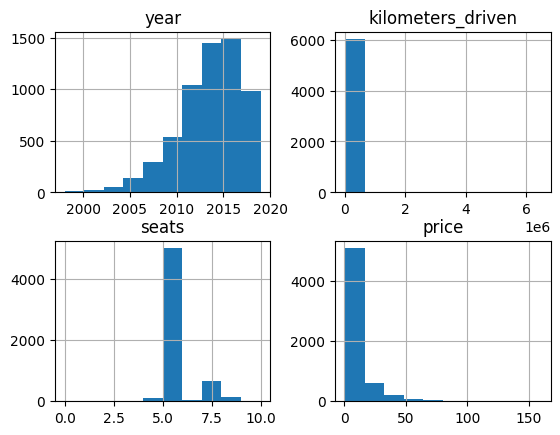

In [13]:
df.hist()

In [14]:
df.describe()

,year,kilometers_driven,seats,price
count,6019.000000,6.019000e+03,5977.000000,6019.000000
mean,2013.358199,5.873838e+04,5.278735,9.479468
std,3.269742,9.126884e+04,0.808840,11.187917
min,1998.000000,1.710000e+02,0.000000,0.440000
25%,2011.000000,3.400000e+04,5.000000,3.500000
50%,2014.000000,5.300000e+04,5.000000,5.640000
75%,2016.000000,7.300000e+04,5.000000,9.950000
max,2019.000000,6.500000e+06,10.000000,160.000000


In [15]:
df.describe(include = 'O')

,name,location,fuel_type,transmission,owner_type,mileage,engine,power
count,6019,6019,6019,6019,6019,6017,5983,5983
unique,1876,11,5,2,4,442,146,372
top,Mahindra XUV500 W8 2WD,Mumbai,Diesel,Manual,First,18.9 kmpl,1197 CC,74 bhp
freq,49,790,3205,4299,4929,172,606,235


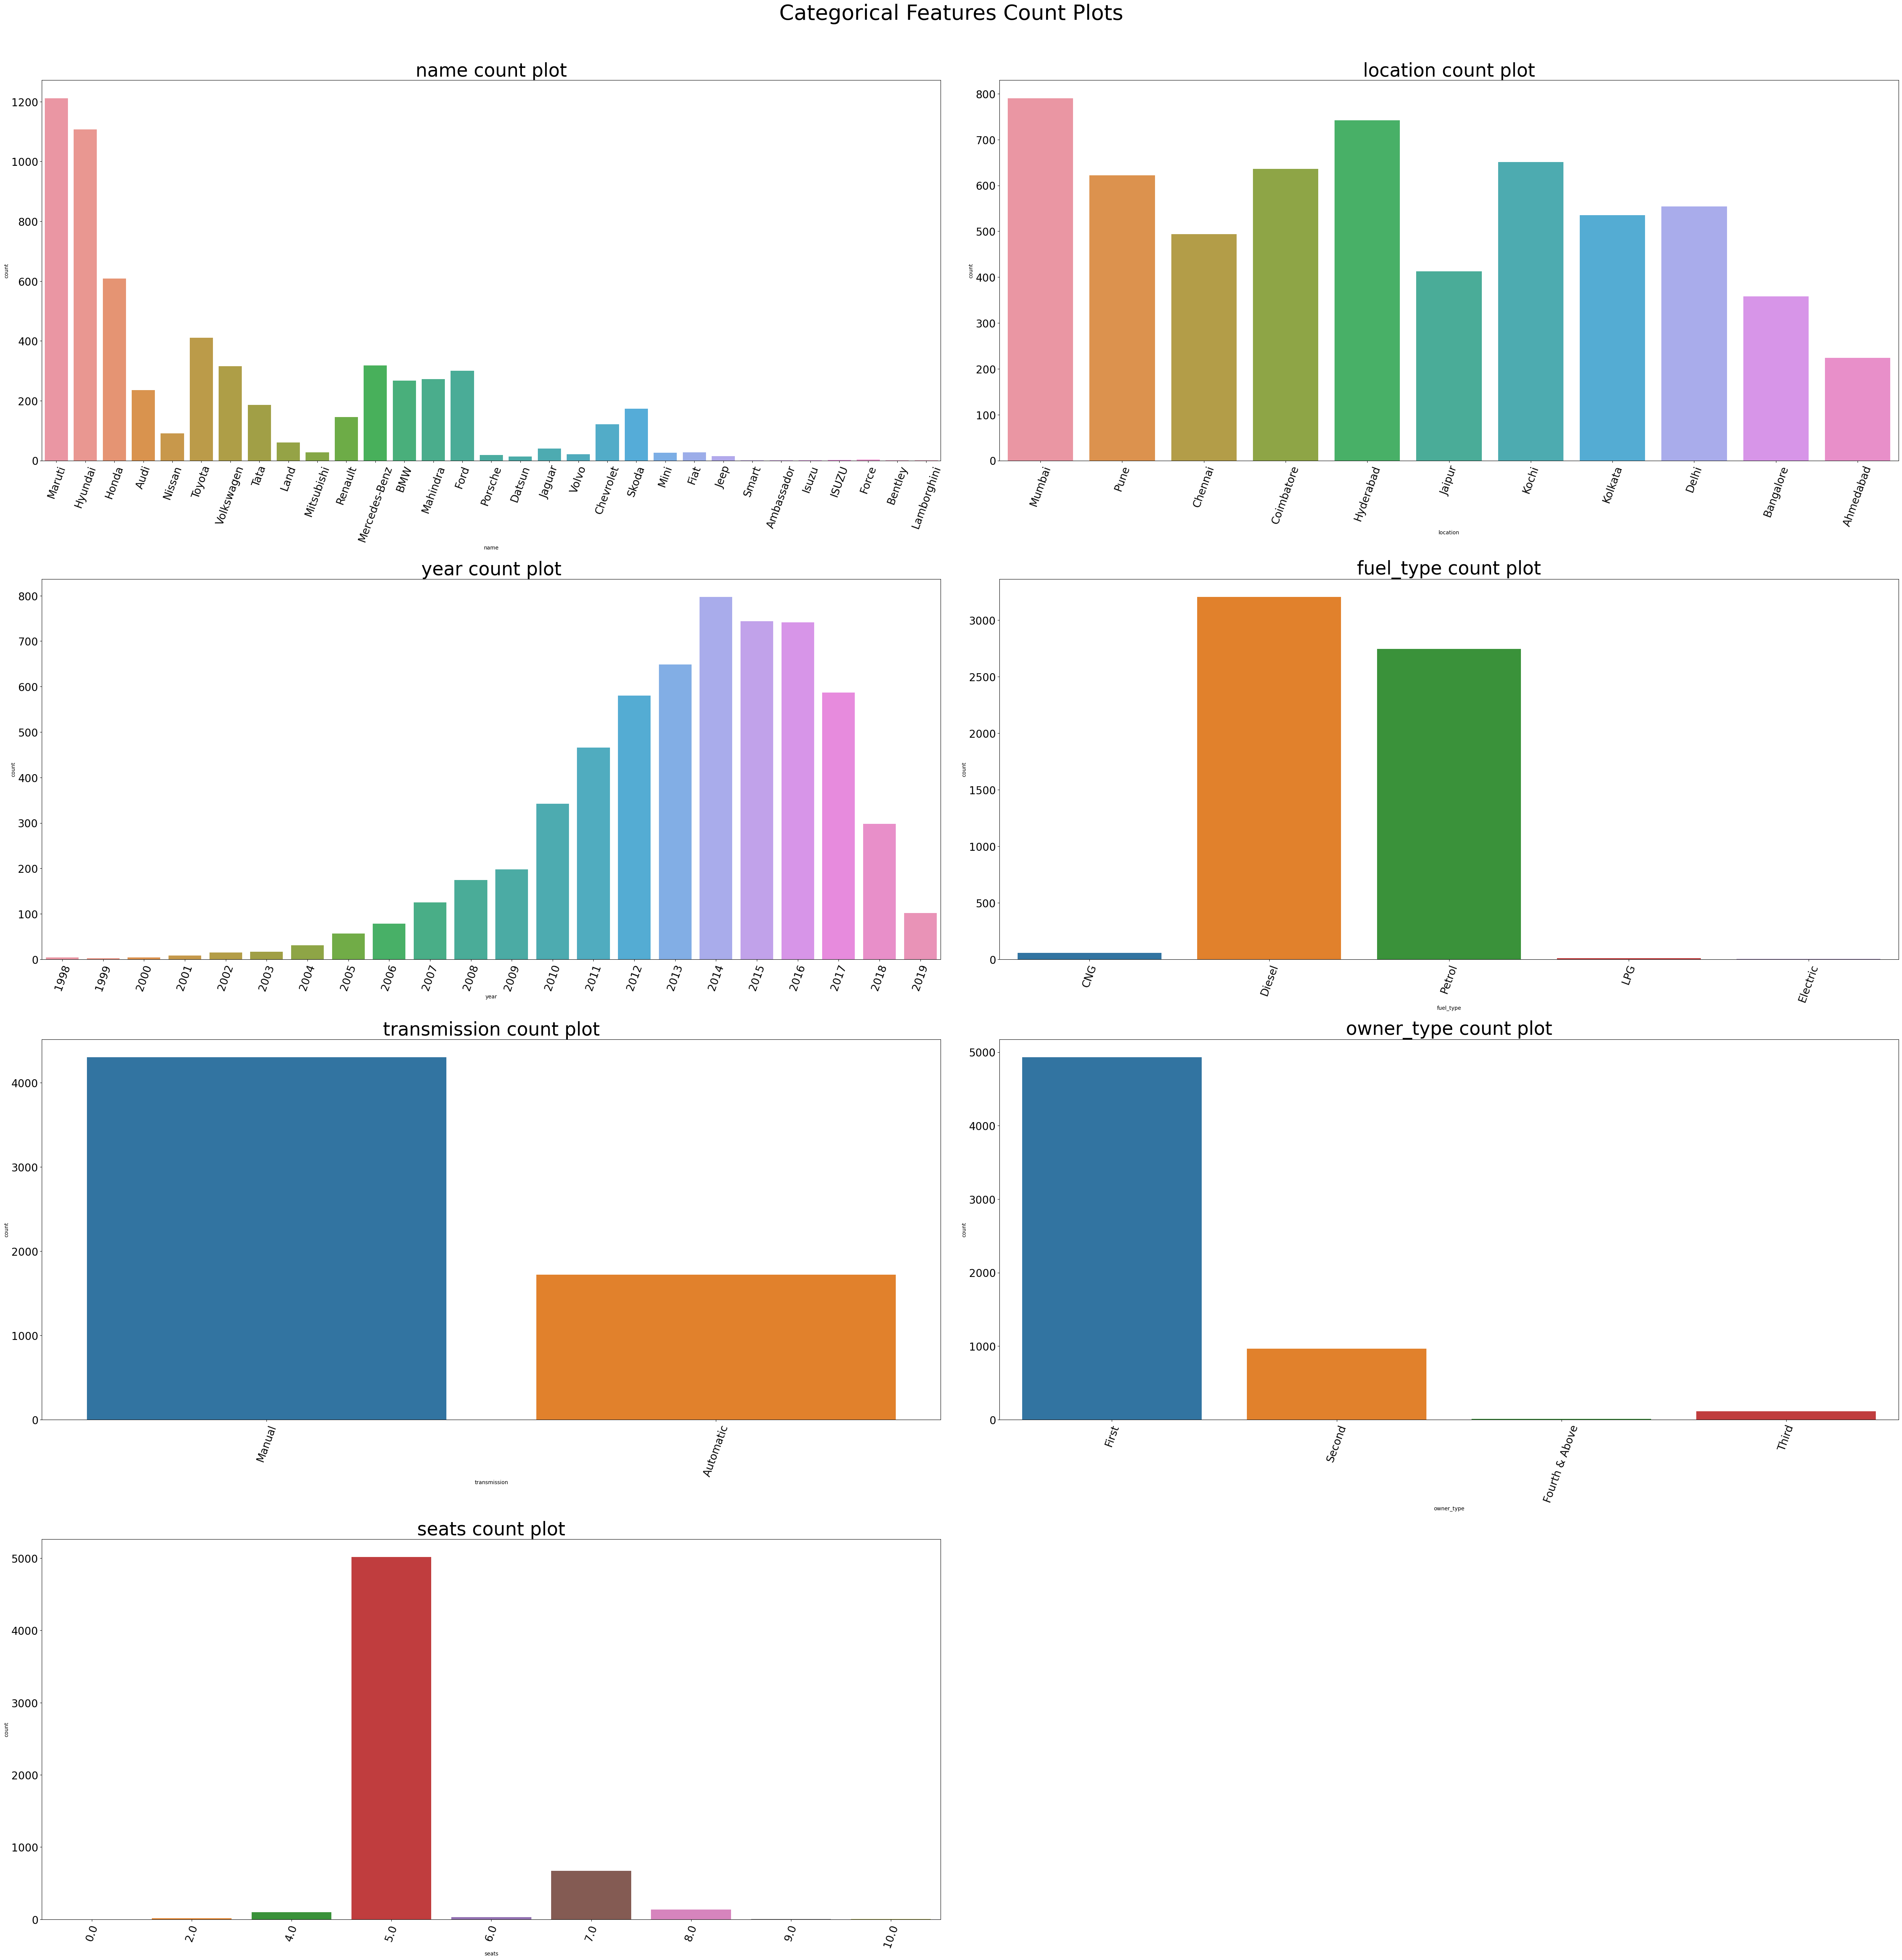

In [16]:
df['name'] = df['name'].str.split().str[0]
fig, axs = plt.subplots(4, 2, figsize=(50, 50), constrained_layout=True)

# Flattening axs array so you can access subplots linearly
axs = axs.ravel()
for i, c in enumerate(categorical_features.columns):
    sns.countplot(data=df, x=c, ax=axs[i])
    axs[i].set_title('{} count plot'.format(c), fontsize=35)
    axs[i].tick_params(axis='x', rotation=70, labelsize=20)
    axs[i].tick_params(axis='y', labelsize=20)

# Hide any extra empty subplots
for j in range(len(categorical_features.columns), len(axs)):
    fig.delaxes(axs[j])

plt.suptitle('Categorical Features Count Plots', x=0.5, y=1.03, fontsize=40)
plt.show()


In [17]:
df['seats'].value_counts()

seats
5.0     5014
7.0      674
8.0      134
4.0       99
6.0       31
2.0       16
10.0       5
9.0        3
0.0        1
Name: count, dtype: int64

In [18]:
df.drop(df[df['seats'] == 0].index, axis = 0 , inplace = True)

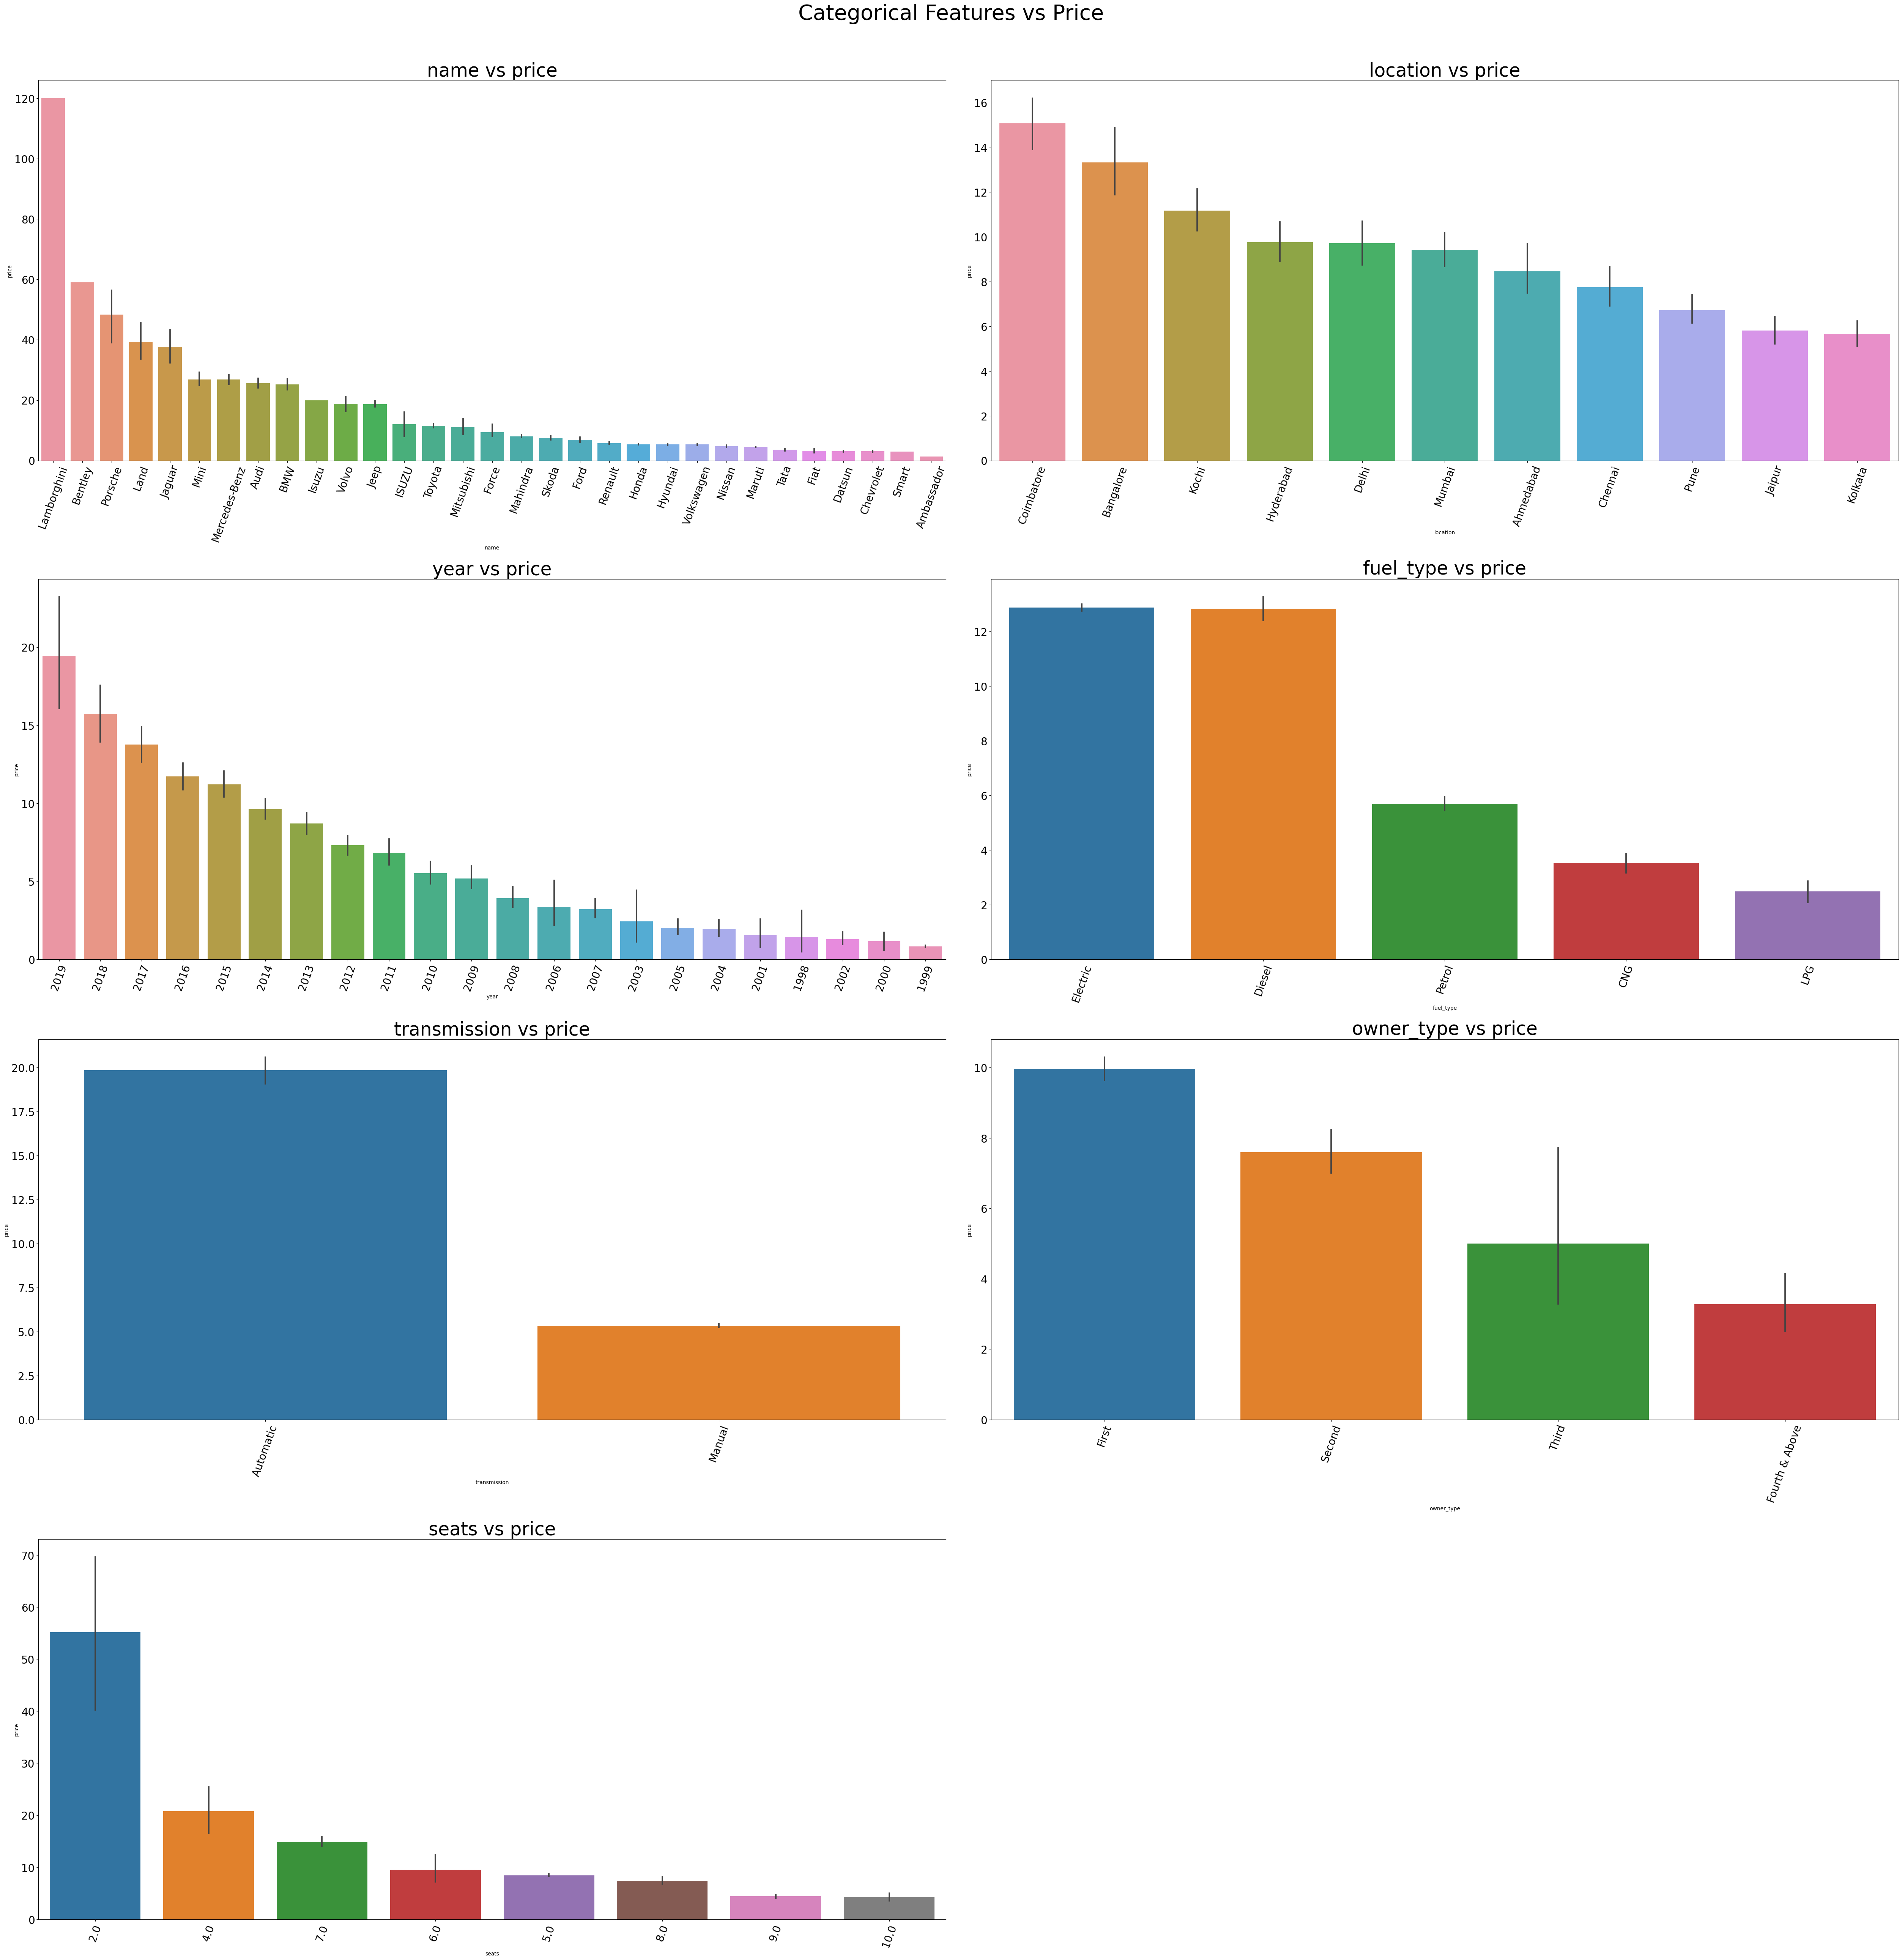

In [19]:
fig, axs = plt.subplots(4, 2, figsize=(50, 50), constrained_layout=True)
axs = axs.flatten()
for i, c in enumerate(categorical_features.columns):
    order = df.groupby(c)['price'].mean().sort_values(ascending=False).index
    sns.barplot(data=df, x=c, y='price', ax=axs[i], order=order)
    
    axs[i].set_title('{} vs price'.format(c),fontsize=35)
    axs[i].tick_params(axis='x', rotation=70, labelsize=20)
    axs[i].tick_params(axis='y', labelsize=20)
for j in range(len(categorical_features.columns), len(axs)):
    fig.delaxes(axs[j])

plt.suptitle('Categorical Features vs Price', x=0.5, y=1.03, fontsize=40)
plt.show()



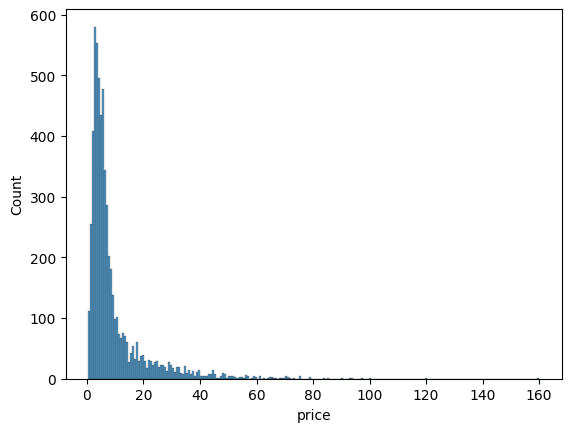

In [20]:
plt.figure()
sns.histplot(df['price'])
plt.show()

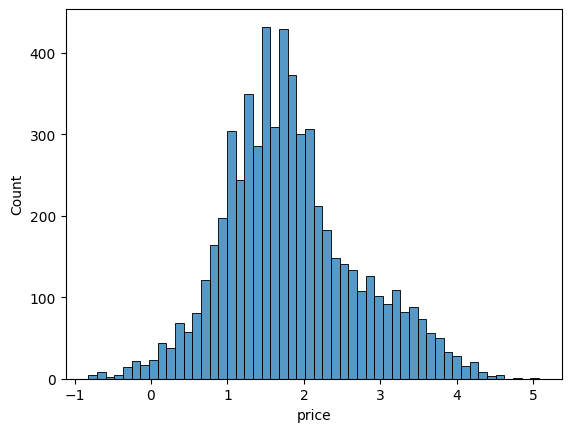

In [21]:
df['price'] = np.log(df['price'])
plt.figure()
sns.histplot(df['price'])
plt.show()

# Preprocessing

In [22]:
df.head()

,name,location,year,kilometers_driven,fuel_type,transmission,owner_type,mileage,engine,power,seats,price
0,Maruti,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,0.559616
1,Hyundai,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,2.525729
2,Honda,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,1.504077
3,Maruti,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,1.791759
4,Audi,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,2.875822


In [23]:
def mileage_convert(x):
    if type(x) == str:
        if x.split()[-1] == 'km/kg':
            return float(x.split()[0])*1.40
        elif x.split()[-1] == 'kmpl':
            return float(x.split()[0])
    else:
        np.nan

df['mileage'] = df['mileage'].apply(mileage_convert)
df.head()

,name,location,year,kilometers_driven,fuel_type,transmission,owner_type,mileage,engine,power,seats,price
0,Maruti,Mumbai,2010,72000,CNG,Manual,First,37.24,998 CC,58.16 bhp,5.0,0.559616
1,Hyundai,Pune,2015,41000,Diesel,Manual,First,19.67,1582 CC,126.2 bhp,5.0,2.525729
2,Honda,Chennai,2011,46000,Petrol,Manual,First,18.20,1199 CC,88.7 bhp,5.0,1.504077
3,Maruti,Chennai,2012,87000,Diesel,Manual,First,20.77,1248 CC,88.76 bhp,7.0,1.791759
4,Audi,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968 CC,140.8 bhp,5.0,2.875822


In [24]:
# For columns with string data, split the string and take the first part
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.split().str[0]
 # Convert numeric columns to integers, coercing errors
df['mileage'] = pd.to_numeric(df['mileage'], errors='coerce').fillna(0).astype(float)
df['engine'] = pd.to_numeric(df['engine'], errors='coerce').fillna(0).astype(float)
df['power'] = pd.to_numeric(df['power'], errors='coerce').fillna(0).astype(float)

    
# Ensure 'year' is treated as a string (if that's the intent)
df['year'] = df['year'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6018 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               6018 non-null   object 
 1   location           6018 non-null   object 
 2   year               6018 non-null   object 
 3   kilometers_driven  6018 non-null   int64  
 4   fuel_type          6018 non-null   object 
 5   transmission       6018 non-null   object 
 6   owner_type         6018 non-null   object 
 7   mileage            6018 non-null   float64
 8   engine             6018 non-null   float64
 9   power              6018 non-null   float64
 10  seats              5976 non-null   float64
 11  price              6018 non-null   float64
dtypes: float64(5), int64(1), object(6)
memory usage: 611.2+ KB


In [25]:
df.head()

,name,location,year,kilometers_driven,fuel_type,transmission,owner_type,mileage,engine,power,seats,price
0,Maruti,Mumbai,2010,72000,CNG,Manual,First,37.24,998.0,58.16,5.0,0.559616
1,Hyundai,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,2.525729
2,Honda,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,1.504077
3,Maruti,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,1.791759
4,Audi,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,2.875822


# Outliers Handeling

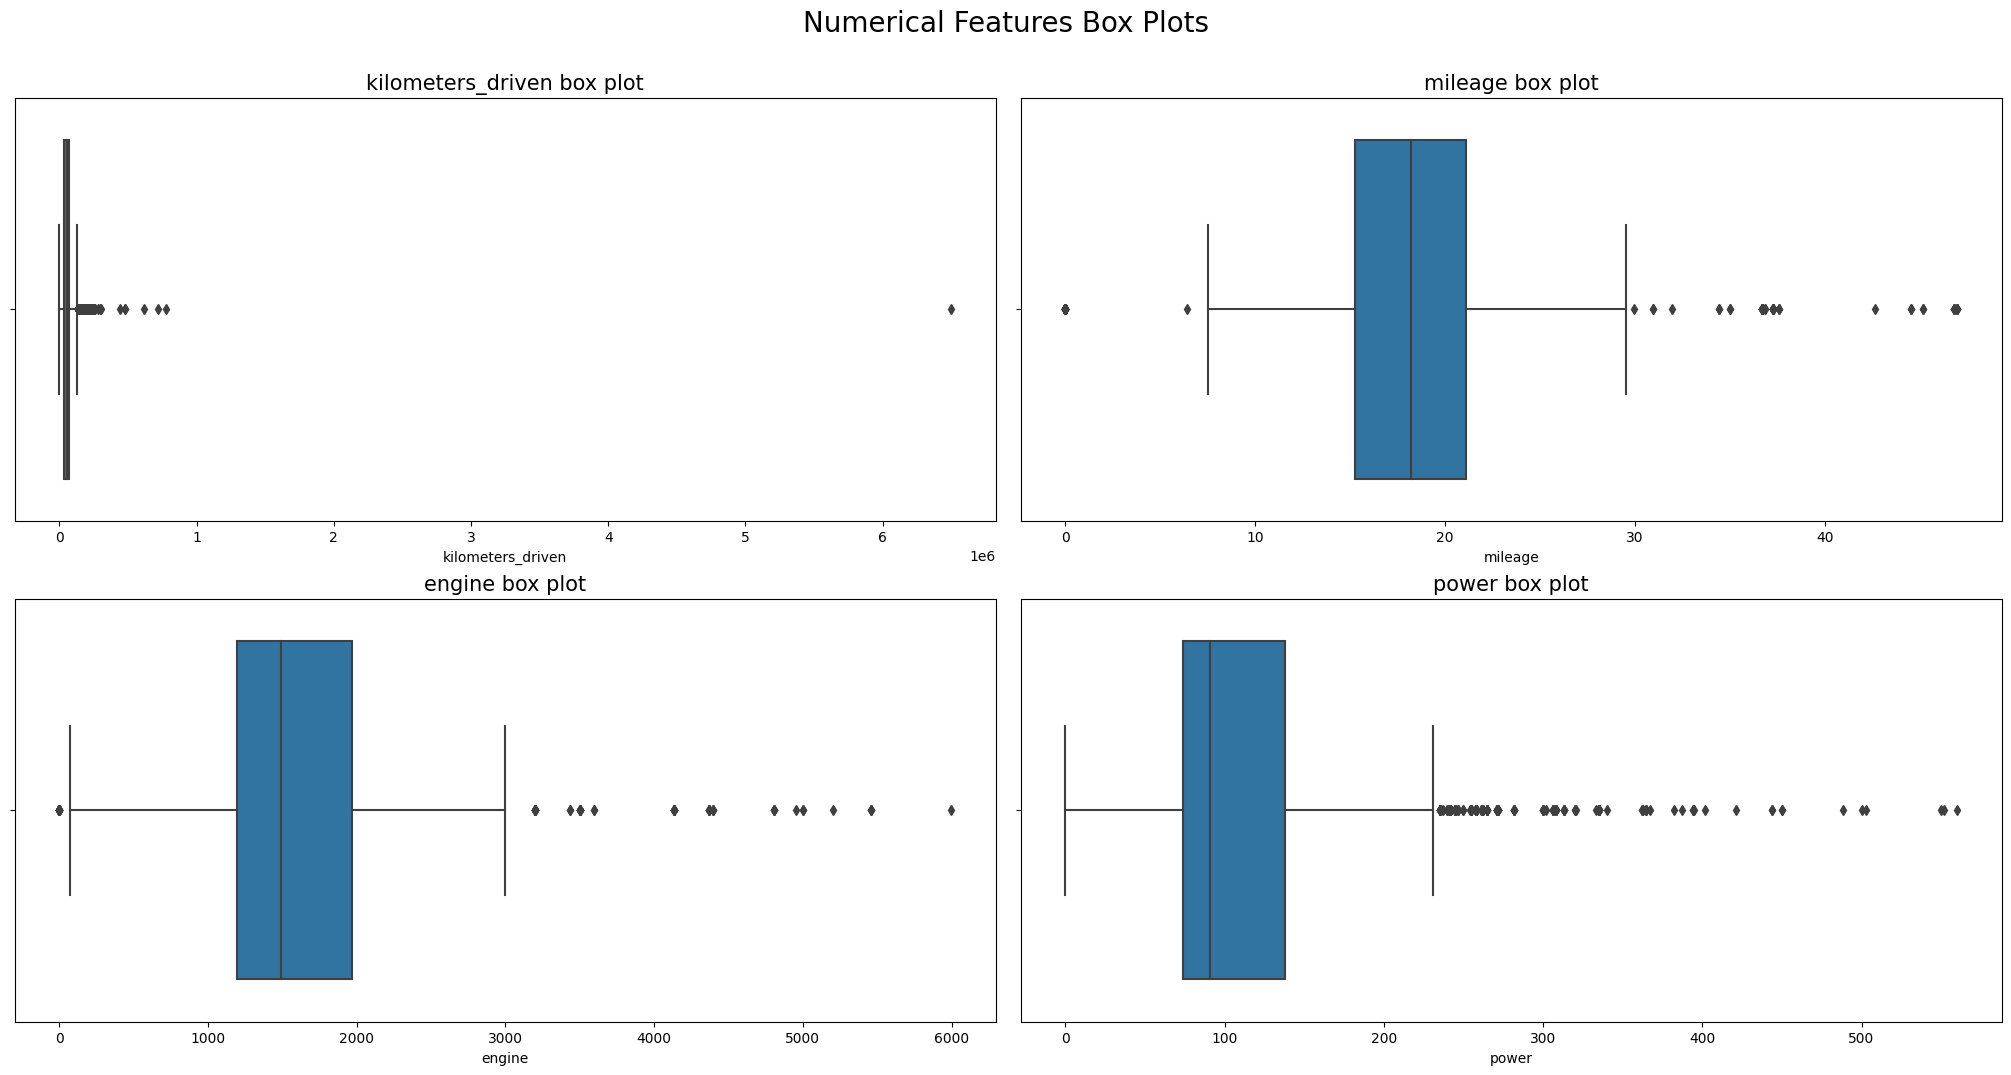

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10), constrained_layout=True)
axs = axs.flatten()
for i, c in enumerate(numerical_features.columns):
    sns.boxplot(data=df, x=c, ax=axs[i])
    axs[i].set_title('{} box plot'.format(c), fontsize=15)
for j in range(len(categorical_features.columns), len(axs)):
    fig.delaxes(axs[j])

plt.suptitle('Numerical Features Box Plots', x=0.5, y=1.06, fontsize=20)
plt.show()

In [27]:
def outliers_handling(x, p1=0.25 , p2=0.75):
    ql = x.quantile(p1)
    q3 = x.quantile(p2)
    iqr = q3 - ql
    min_limit = ql - 1.5 * iqr
    max_limit = q3 + 1.5 * iqr
    return x[(x > min_limit) & (x < max_limit)]

In [28]:
for col in numerical_features:
    df[col] = outliers_handling(df[col])

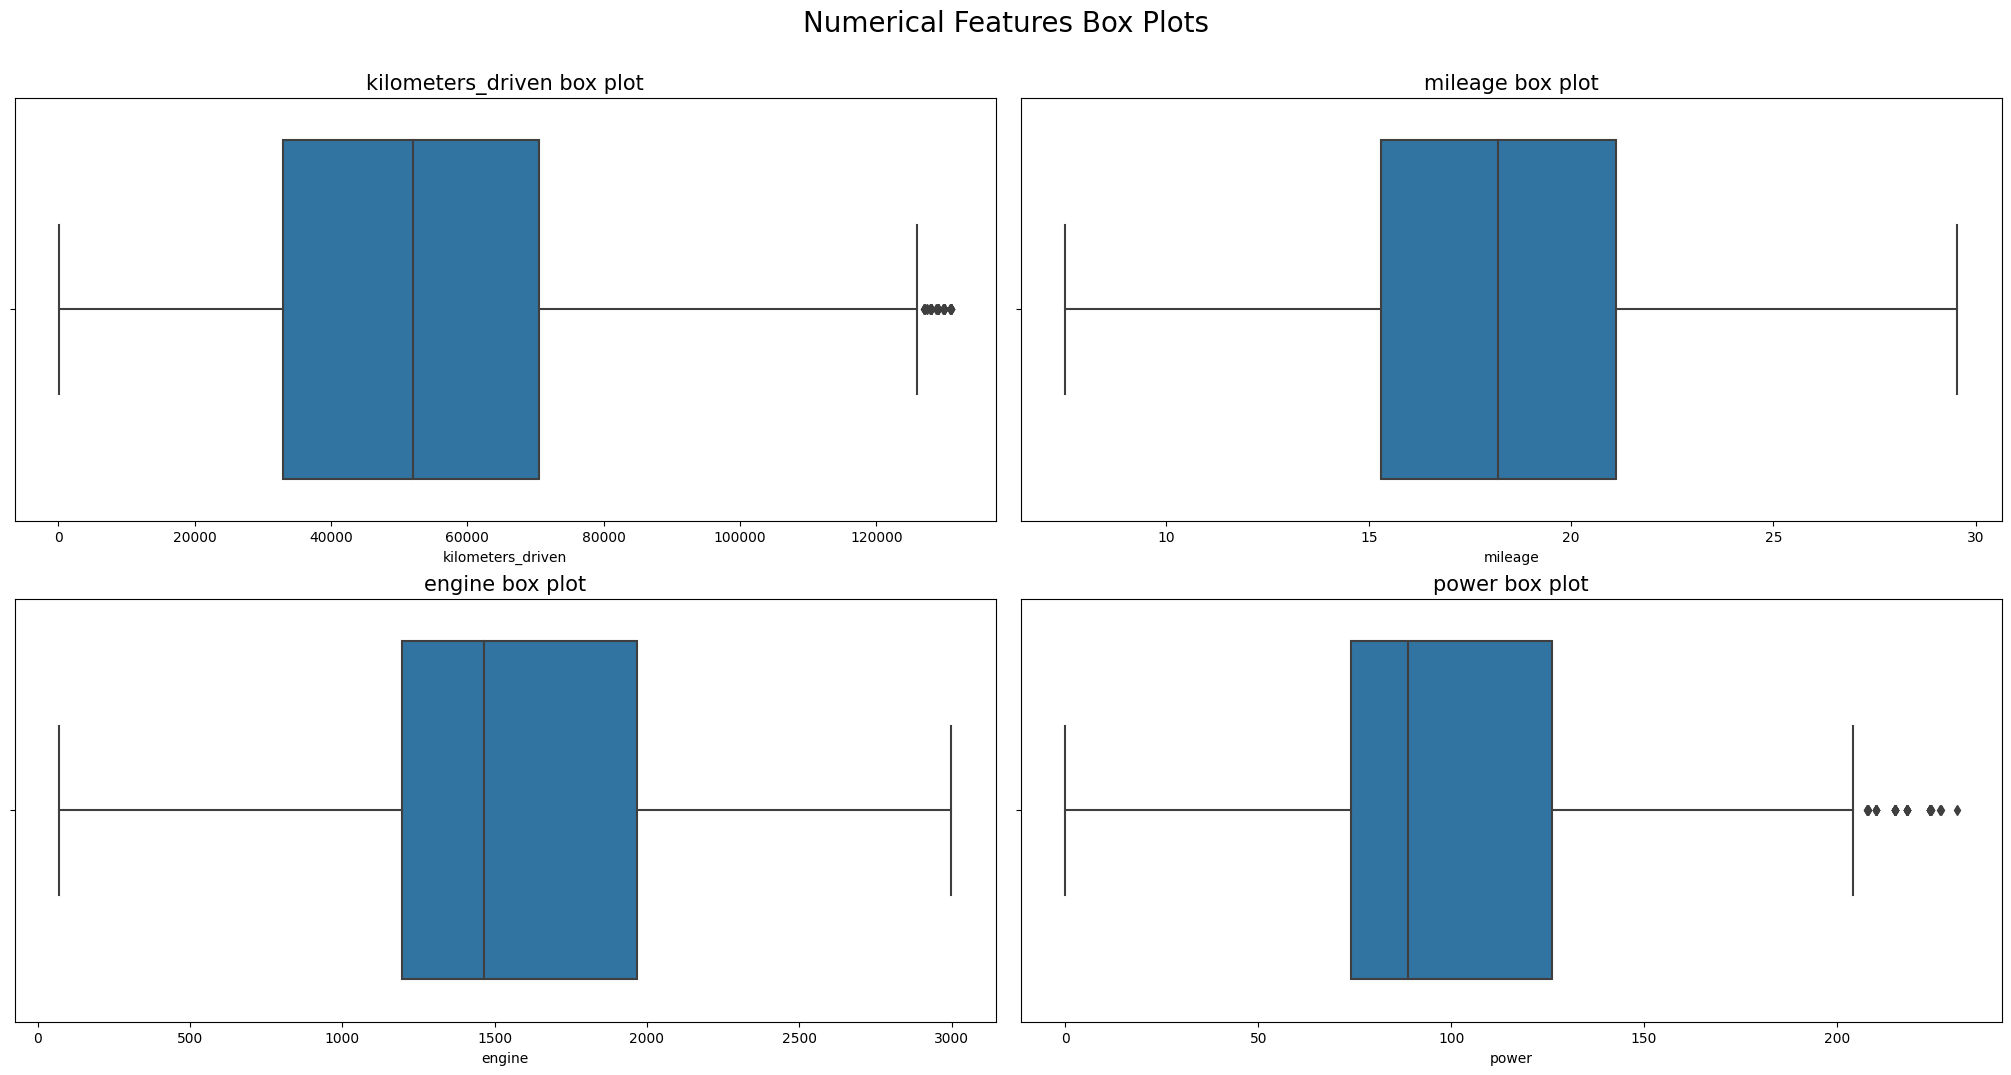

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10), constrained_layout=True)
axs = axs.flatten()
for i, c in enumerate(numerical_features.columns):
    sns.boxplot(data=df, x=c, ax=axs[i])
    axs[i].set_title('{} box plot'.format(c), fontsize=15)

plt.suptitle('Numerical Features Box Plots', x=0.5, y=1.06, fontsize=20)
plt.show()

In [30]:
df.head()

,name,location,year,kilometers_driven,fuel_type,transmission,owner_type,mileage,engine,power,seats,price
0,Maruti,Mumbai,2010,72000.0,CNG,Manual,First,NaN,998.0,58.16,5.0,0.559616
1,Hyundai,Pune,2015,41000.0,Diesel,Manual,First,19.67,1582.0,126.20,5.0,2.525729
2,Honda,Chennai,2011,46000.0,Petrol,Manual,First,18.20,1199.0,88.70,5.0,1.504077
3,Maruti,Chennai,2012,87000.0,Diesel,Manual,First,20.77,1248.0,88.76,7.0,1.791759
4,Audi,Coimbatore,2013,40670.0,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,2.875822


# Data Spliting

In [31]:
x = df.drop(['price'],axis = 1)
y = df['price']

In [32]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.2)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4814, 11)
(4814,)
(1204, 11)
(1204,)


In [33]:
cal_cols = categorical_features.columns.tolist()
num_cols = numerical_features.columns.tolist()
print(cal_cols)
print(num_cols)

['name', 'location', 'year', 'fuel_type', 'transmission', 'owner_type', 'seats']
['kilometers_driven', 'mileage', 'engine', 'power']


In [34]:
nominal_cols = ['name', 'location', 'fuel_type', 'transmission']
ordinal_cols = ['year', 'owner_type', 'seats']

In [35]:
num_pipeline = Pipeline([
    ('num_imputer', SimpleImputer(strategy = 'median')),
    ('poly', PolynomialFeatures(degree = 3)),
    ('scaler', StandardScaler())
])

ordinal_pipeline = Pipeline([
    ('ord_imputer', SimpleImputer(strategy = 'most_frequent')),
    ('ord_encoder', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)),
])

nominal_pipeline = Pipeline([
    ('nom_imputer', SimpleImputer(strategy = 'most_frequent')),
    ('ohe', OneHotEncoder(drop = 'first', sparse_output = False, handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer([
    ('num_pipeline', num_pipeline, num_cols),
    ('ordinal_pipeline', ordinal_pipeline, ordinal_cols),
    ('nominal_pipeline', nominal_pipeline, nominal_cols)
]).set_output(transform = 'pandas')

In [36]:
x_train_prep = preprocessor.fit_transform(x_train)
x_test_prep = preprocessor.transform(x_test)

In [37]:
x_train_prep

,num_pipeline__1,num_pipeline__kilometers_driven,num_pipeline__mileage,num_pipeline__engine,num_pipeline__power,num_pipeline__kilometers_driven^2,num_pipeline__kilometers_driven mileage,num_pipeline__kilometers_driven engine,num_pipeline__kilometers_driven power,num_pipeline__mileage^2,...,nominal_pipeline__location_Jaipur,nominal_pipeline__location_Kochi,nominal_pipeline__location_Kolkata,nominal_pipeline__location_Mumbai,nominal_pipeline__location_Pune,nominal_pipeline__fuel_type_Diesel,nominal_pipeline__fuel_type_Electric,nominal_pipeline__fuel_type_LPG,nominal_pipeline__fuel_type_Petrol,nominal_pipeline__transmission_Manual
4087,0.0,-1.249755,1.195317,-1.091034,-0.842609,-0.957587,-0.967261,-1.144738,-1.091218,1.210923,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3532,0.0,-0.067527,-0.657008,-0.727718,-0.773258,-0.273349,-0.302180,-0.435760,-0.498088,-0.701520,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4551,0.0,-0.067190,1.042191,0.738392,2.038264,-0.273068,0.386785,0.264650,1.119544,1.024722,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
434,0.0,-1.064523,0.521071,-0.241461,0.127600,-0.890277,-0.877579,-0.864648,-0.734661,0.428992,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1602,0.0,1.144002,-0.533520,-1.461690,-1.546427,1.054372,0.759020,-0.348566,-0.629909,-0.597085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2682,0.0,-1.305100,1.057010,-0.360732,-0.334426,-0.974822,-1.053656,-1.044615,-1.012184,1.042520,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2471,0.0,1.332265,0.266684,-0.724048,-0.632682,1.317622,1.475525,0.327081,0.325370,0.159495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
949,0.0,1.106469,-0.360636,-0.182743,0.163916,1.003721,0.840354,0.619982,0.942413,-0.445342,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2793,0.0,-0.165082,-1.916590,2.279734,0.098314,-0.352671,-0.865704,0.874853,-0.069761,-1.578576,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# Model Training

In [38]:
# Dictionary containing regression models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(),
    'ElasticNet' : ElasticNet(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'SVR' : SVR(),
}

# Dictionary to store the mean R² scores for each model
model_results = {}

# Train and evaluate models
for model_name, model in models.items():
    scores = cross_val_score(model, x_train_prep, y_train, cv=5, scoring='r2')
    model_results[model_name] = scores.mean()
    #print(f'{model_name}: Mean R² Score = {scores.mean():.4f}')
    
print("\nFinal Results:")
for model_name, score in model_results.items():
    print(f'{model_name}: {score:.4f}')


Final Results:
LinearRegression: 0.9208
Ridge: 0.9177
Lasso: 0.1413
ElasticNet: 0.3358
DecisionTreeRegressor: 0.8581
RandomForestRegressor: 0.9271
KNeighborsRegressor: 0.8792
SVR: 0.8935


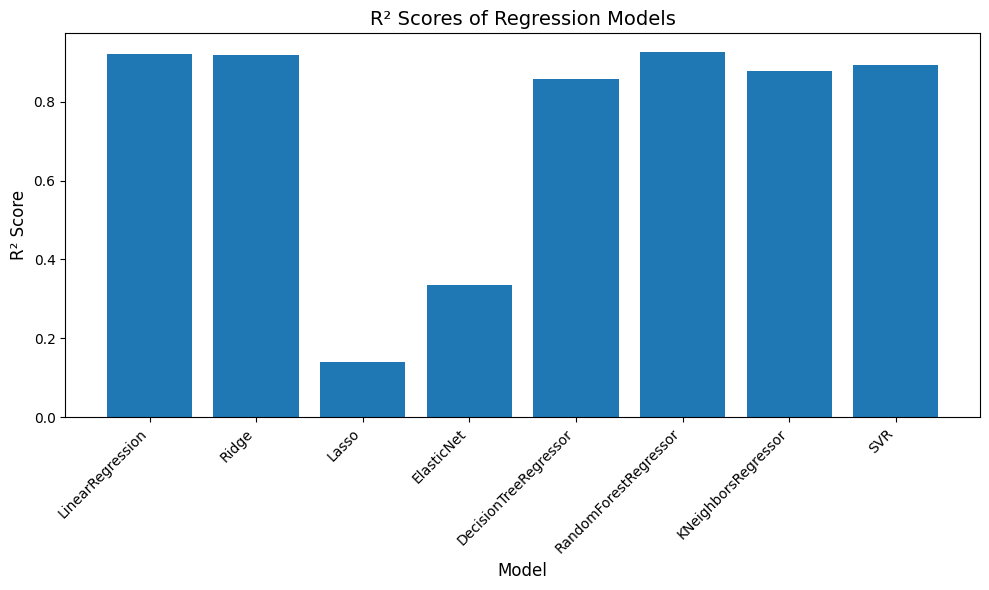

In [39]:
model_names = list(model_results.keys())
r2_scores = list(model_results.values())

plt.figure(figsize=(10, 6))
plt.bar(model_names, r2_scores)

plt.xlabel('Model', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('R² Scores of Regression Models', fontsize=14)
plt.xticks(rotation=45, ha='right') 

plt.tight_layout()
plt.show()

In [40]:
sorted_results = sorted(model_results.items(), key=lambda x: x[1], reverse=True)
top_two_models = sorted_results[:2]
for model_name, r2_score in top_two_models:
    print(f'{model_name}: {r2_score:.4f}')

RandomForestRegressor: 0.9271
LinearRegression: 0.9208


# Hyperparameter Tuning

In [41]:
best_model = None  # To store the best model
best_score = -float('inf')  # To store the best R² score
best_model_name = ''  # To store the name of the best model
best_params = {}  # To store the best hyperparameters
model_results = {}  # To store the results of each model

# Loop through each model and perform GridSearchCV with hyperparameter tuning
for model_name, model in models.items():
    print(f"Running GridSearchCV for {model_name}...")

    # Build a pipeline with preprocessor and the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  
        (model_name.lower(), model)
    ])

    # Define parameter grid for each model
    if model_name in ['Ridge', 'Lasso']:
        params = {
            'preprocessor__num_pipeline__poly__degree': [2, 3, 4, 5],
            f'{model_name.lower()}__alpha': [0.1, 1, 10]
        }
    elif model_name == 'ElasticNet':
        params = {
            'preprocessor__num_pipeline__poly__degree': [2, 3, 4, 5],
            f'{model_name.lower()}__alpha': [0.1, 1, 10],
            f'{model_name.lower()}__l1_ratio': [0.1, 0.5, 0.9]
        }
    elif model_name == 'RandomForestRegressor':
        params = {
            'preprocessor__num_pipeline__poly__degree': [2, 3],
            f'{model_name.lower()}__n_estimators': [100, 200],
            f'{model_name.lower()}__max_depth': [None, 10, 20]
        }
    elif model_name == 'DecisionTreeRegressor':
        params = {
            'preprocessor__num_pipeline__poly__degree': [2, 3],
            f'{model_name.lower()}__max_depth': [None, 10, 20]
        }
    elif model_name == 'KNeighborsRegressor':
        params = {
            'preprocessor__num_pipeline__poly__degree': [2, 3],
            f'{model_name.lower()}__n_neighbors': [3, 5, 7]
        }
    elif model_name == 'SVR':
        params = {
            'preprocessor__num_pipeline__poly__degree': [2, 3],
            f'{model_name.lower()}__C': [0.1, 1, 10],
            f'{model_name.lower()}__epsilon': [0.01, 0.1, 1]
        }
    else:
        params = {
            'preprocessor__num_pipeline__poly__degree': [2, 3]
        }

    # Perform GridSearchCV
    grid_search = GridSearchCV(pipeline, params, cv=3, scoring='r2')
    grid_search.fit(x_train, y_train)

    # Store the results in the model_results dictionary
    model_results[model_name] = pd.DataFrame(grid_search.cv_results_)

    # Print the best parameters for the model
    print(f"Best parameters for {model_name}: {grid_search.best_params_}\n")

# To view the results for each model:
for model_name, result_df in model_results.items():
    print(f"Results for {model_name}:")
    print(result_df[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False))
    print("\n")


Running GridSearchCV for LinearRegression...
Best parameters for LinearRegression: {'preprocessor__num_pipeline__poly__degree': 3}

Running GridSearchCV for Ridge...
Best parameters for Ridge: {'preprocessor__num_pipeline__poly__degree': 5, 'ridge__alpha': 0.1}

Running GridSearchCV for Lasso...
Best parameters for Lasso: {'lasso__alpha': 0.1, 'preprocessor__num_pipeline__poly__degree': 4}

Running GridSearchCV for ElasticNet...
Best parameters for ElasticNet: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.1, 'preprocessor__num_pipeline__poly__degree': 5}

Running GridSearchCV for DecisionTreeRegressor...
Best parameters for DecisionTreeRegressor: {'decisiontreeregressor__max_depth': 10, 'preprocessor__num_pipeline__poly__degree': 2}

Running GridSearchCV for RandomForestRegressor...
Best parameters for RandomForestRegressor: {'preprocessor__num_pipeline__poly__degree': 2, 'randomforestregressor__max_depth': 20, 'randomforestregressor__n_estimators': 200}

Running GridSearchCV fo

In [42]:
# Check if this model has the best score so far
if grid_search.best_score_ > best_score:
    best_score = grid_search.best_score_
    best_model = grid_search.best_estimator_
    best_model_name = model_name
    best_params = grid_search.best_params_

# Print the best model and its score
print(f"Best Model: {best_model_name} with R² Score: {best_score}")
print(f"Best Parameters: {best_params}")

Best Model: SVR with R² Score: 0.92653413129487
Best Parameters: {'preprocessor__num_pipeline__poly__degree': 3, 'svr__C': 10, 'svr__epsilon': 0.1}


# Save Model

In [43]:
import pickle
pickle.dump(best_model, open('model.pkl', 'wb'))

In [44]:
# Load the model
with open('model.pkl', 'rb') as file:
    best_model = pickle.load(file)

# Make predictions
y_pred = best_model.predict(x_test)
y_pred

array([3.76168336, 3.58441411, 1.80564794, ..., 1.89140239, 1.94133458,
       1.95684112])

In [45]:
y_test

2153    3.650658
480     3.511545
3917    1.945910
2425    1.137833
2269    1.731656
          ...   
2954    1.609438
3709    1.704748
5006    1.776646
1116    2.222459
3946    1.791759
Name: price, Length: 1204, dtype: float64

In [46]:
print('y_test shape:', y_test.shape)  
print('y_pred shape:', y_pred.shape)  

y_test shape: (1204,)
y_pred shape: (1204,)


In [47]:
mean_y = np.mean(y_test)

# Calculate SS_res and SS_tot
SS_res = np.sum((y_test - y_pred) ** 2)
SS_tot = np.sum((y_test - mean_y) ** 2)

# Calculate R² score
r2_manual = 1 - (SS_res / SS_tot)

print('R² Score (manual calculation):', r2_manual)

R² Score (manual calculation): 0.9214877766801041
